In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\Nylle\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# READ IN ALL DATA
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\BB_2021.csv')

In [3]:
import prediction_prep as prep

df = prep.get_regression_df(ticker_name = 'bb', #
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)
df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,2.0,1.0,3.0,33.332222,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,2.0,1.0,3.0,33.332222,0,4.0,2.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,3.0,0.0,3.0,0.000000,0,5.0,2.5,50.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.000000,0,3.0,1.5,-100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.299964,0,0.262337
4,2021-01-05,0.0,1.0,1.0,99.990001,0,0.0,0.0,-100.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.220911,1,-1.509996


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int32         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     344 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: BB Close Price

### Without Normalization

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', 'Low', '5D%Change', '3Dir', 'Volume', 'Daily%Change', '3D%Change', '4Dir', '5Dir', '7Dir', '6Dir', '7D%Change', 'SD_log', '6D%Change', '4D%Change', 'High', 'Dir', 'Open', '2D%Change', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,7.44,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,9.11,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,9.84,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,12.35,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,12.79,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,9.41,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,9.41
246,9.48,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,9.48
247,9.40,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,9.40
248,9.44,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,9.44
249,9.21,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,9.21


In [9]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [10]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.5996602737817465
0.5996602737817465


In [11]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'BB_woSentiment_ClosePrice_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0193
Epoch 1: val_loss improved from inf to 0.01583, saving model to BB_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 4s 103ms/step - loss: 0.0193 - val_loss: 0.0158
Epoch 2/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0077
Epoch 2: val_loss improved from 0.01583 to 0.00301, saving model to BB_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 0s 27ms/step - loss: 0.0101 - val_loss: 0.0030
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0078
Epoch 3: val_loss improved from 0.00301 to 0.00207, saving model to BB_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 0s 26ms/step - loss: 0.0075 - val_loss: 0.0021
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.0060
Epoch 4: val_loss improved from 0.00207 to 0.00144, saving model to BB_woSentiment_ClosePrice_wo

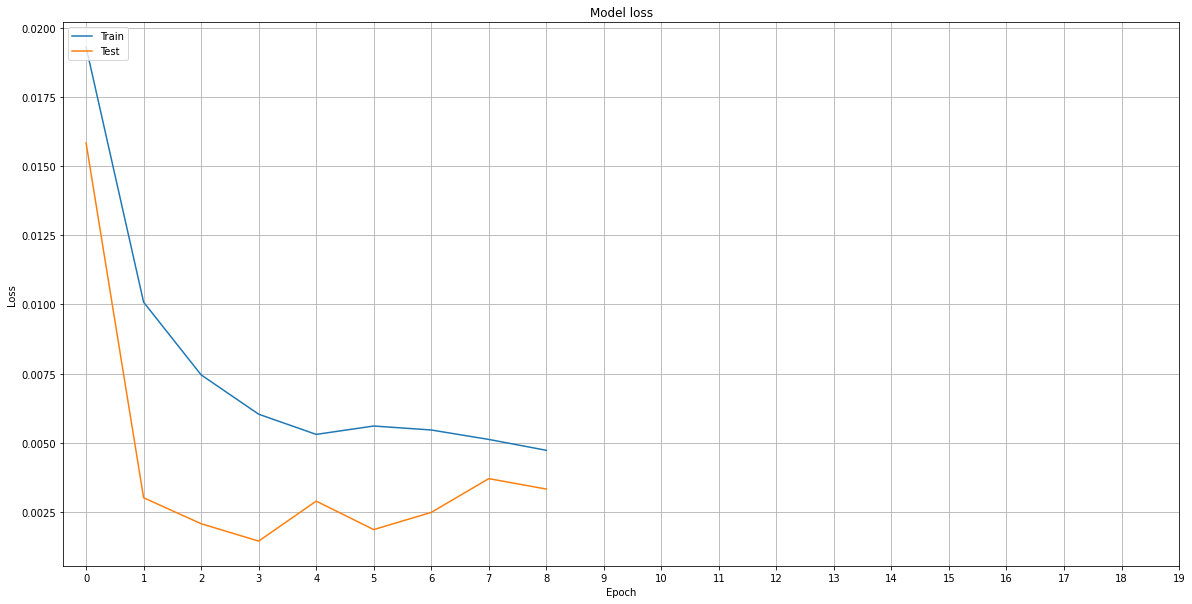

In [13]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.52
Mean Absolute Percentage Error (MAPE): 5.23 %
Median Absolute Percentage Error (MDAPE): 4.08 %


,MAE,MAPE,MDAPE
0,0.519871,5.226872,4.079442


In [15]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

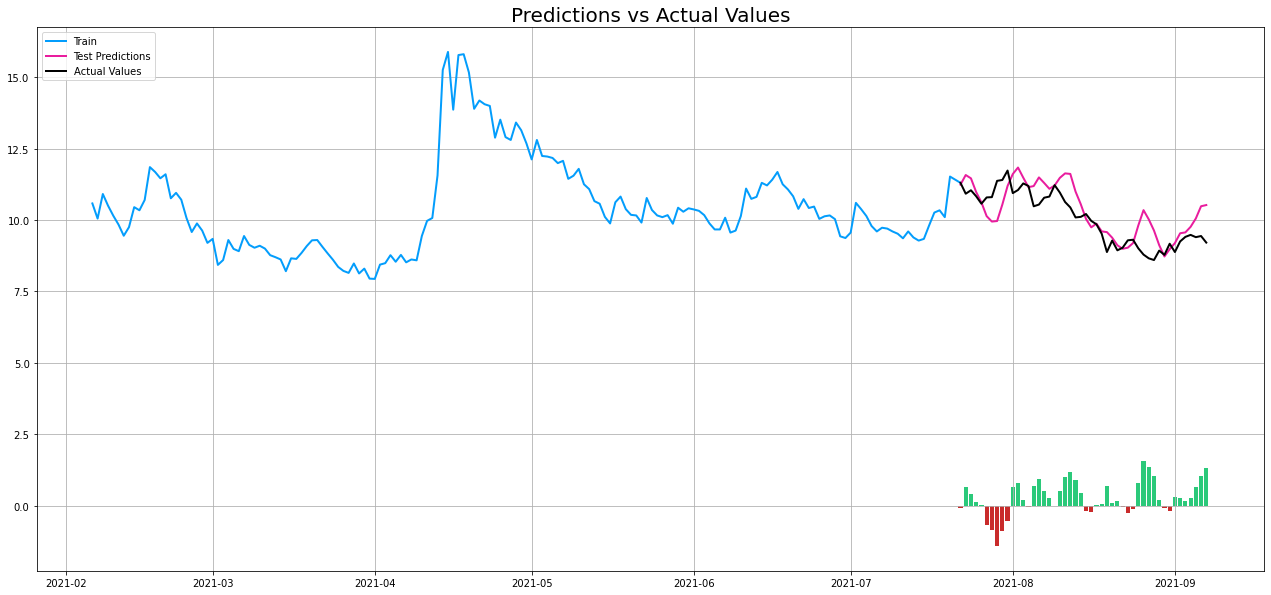

In [16]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [17]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', 'Low', '5D%Change', '3Dir', 'Volume', 'Daily%Change', '3D%Change', '4Dir', '5Dir', '7Dir', '6Dir', '7D%Change', 'SD_log', '6D%Change', '4D%Change', 'High', 'Dir', 'Open', '2D%Change', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,7.44,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,9.11,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,9.84,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,12.35,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,12.79,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [18]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,9.41,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,9.41
246,9.48,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,9.48
247,9.40,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,9.40
248,9.44,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,9.44
249,9.21,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,9.21


In [20]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# # Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# # Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [21]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.5996602737817465
0.5996602737817465


In [22]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'BB_woSentiment_ClosePrice_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0394
Epoch 1: val_loss improved from inf to 0.00328, saving model to BB_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 4s 131ms/step - loss: 0.0394 - val_loss: 0.0033
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0120
Epoch 2: val_loss improved from 0.00328 to 0.00302, saving model to BB_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 0s 28ms/step - loss: 0.0120 - val_loss: 0.0030
Epoch 3/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0103
Epoch 3: val_loss did not improve from 0.00302
12/12 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0040
Epoch 4/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0088
Epoch 4: val_loss did not improve from 0.00302
12/12 [==============================] - 0s 12ms/step - loss: 0.0080 - val_loss: 0.0047
Epoch 5/100
 7/12 [================>.

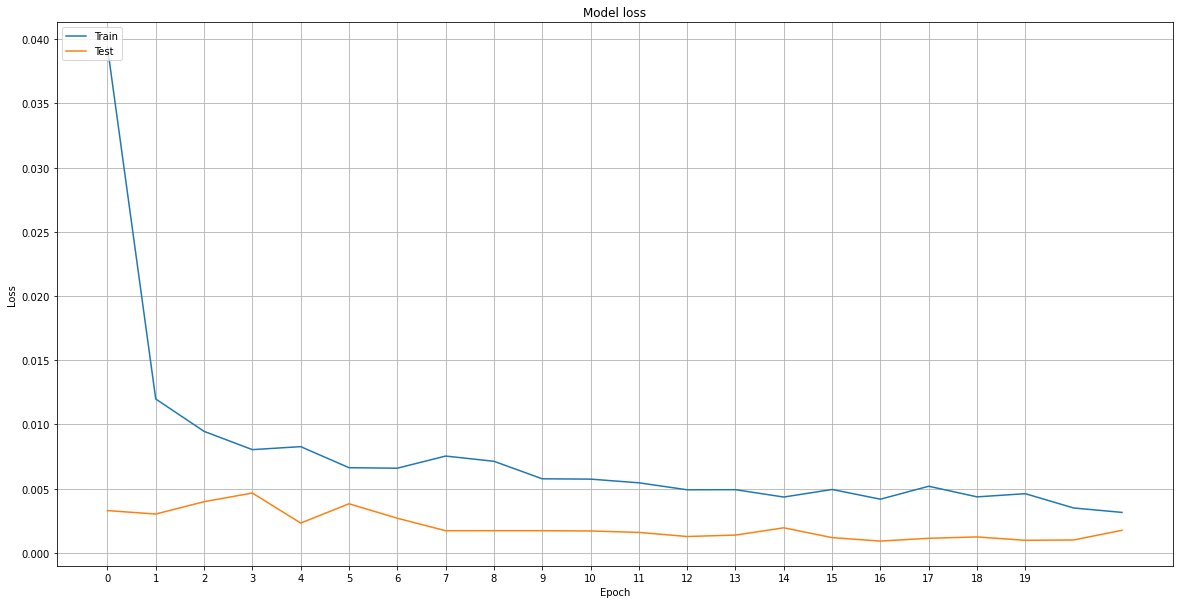

In [24]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]

# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)


    # Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.44
Mean Absolute Percentage Error (MAPE): 4.43 %
Median Absolute Percentage Error (MDAPE): 3.87 %


,MAE,MAPE,MDAPE
0,0.438393,4.433306,3.872192


In [26]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# # Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

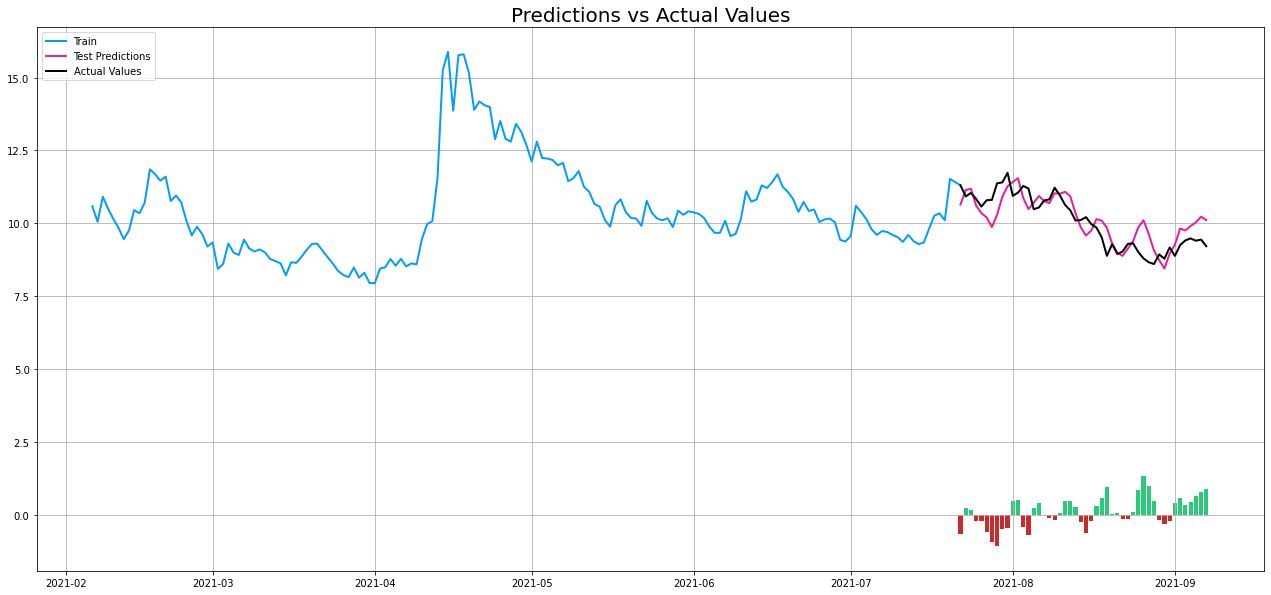

In [27]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: BB Daily%Change

### Without Normalization

In [33]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', 'Low', '5D%Change', '3Dir', 'Volume', '3D%Change', '4Dir', '5Dir', '7Dir', '6Dir', '7D%Change', 'SD_log', '6D%Change', '4D%Change', 'High', 'Dir', 'Close', 'Open', '2D%Change', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,-2.490171,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,22.446231,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,8.013178,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,25.508132,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,3.562750,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [34]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,1.729728,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,1.729728
246,0.743886,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,0.743886
247,-0.843881,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,-0.843881
248,0.425532,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,0.425532
249,-2.436436,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,-2.436436


In [36]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [37]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.9428641473404276
0.9428641473404276


In [38]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'BB_woSentiment_DailyChange_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.0801
Epoch 1: val_loss improved from inf to 0.01244, saving model to BB_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 3s 64ms/step - loss: 0.0801 - val_loss: 0.0124
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0153
Epoch 2: val_loss improved from 0.01244 to 0.00593, saving model to BB_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 0s 14ms/step - loss: 0.0153 - val_loss: 0.0059
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0128
Epoch 3: val_loss improved from 0.00593 to 0.00289, saving model to BB_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 0s 14ms/step - loss: 0.0128 - val_loss: 0.0029
Epoch 4/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0092
Epoch 4: val_loss improved from 0.00289 to 0.00223, saving model to BB_woSentiment_DailyChange

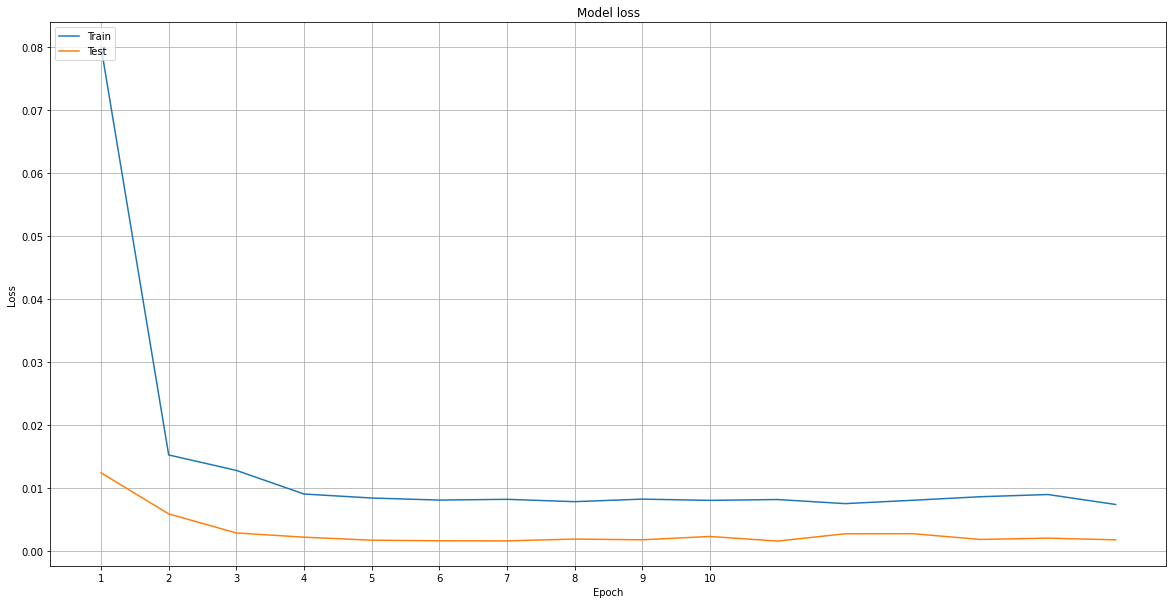

In [40]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 2.36
Mean Absolute Percentage Error (MAPE): 146.62 %
Median Absolute Percentage Error (MDAPE): 93.94 %


,MAE,MAPE,MDAPE
0,2.356836,146.621917,93.941726


In [42]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

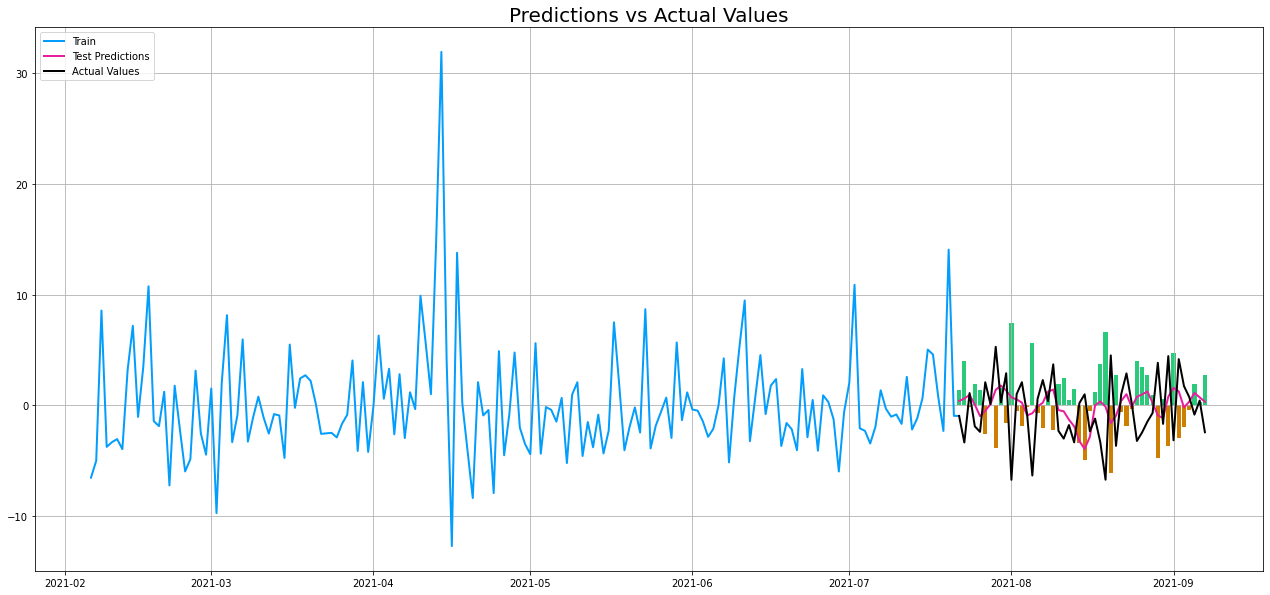

In [43]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [44]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', 'Low', '5D%Change', '3Dir', 'Volume', '3D%Change', '4Dir', '5Dir', '7Dir', '6Dir', '7D%Change', 'SD_log', '6D%Change', '4D%Change', 'High', 'Dir', 'Close', 'Open', '2D%Change', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,-2.490171,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,22.446231,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,8.013178,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,25.508132,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,3.562750,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [45]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,1.729728,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,1.729728
246,0.743886,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,0.743886
247,-0.843881,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,-0.843881
248,0.425532,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,0.425532
249,-2.436436,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,-2.436436


In [46]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [47]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.9428641473404276
0.9428641473404276


In [48]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'BB_woSentiment_DailyChange_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0862
Epoch 1: val_loss improved from inf to 0.00824, saving model to BB_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 4s 72ms/step - loss: 0.0816 - val_loss: 0.0082
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0141
Epoch 2: val_loss improved from 0.00824 to 0.00326, saving model to BB_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 0s 15ms/step - loss: 0.0134 - val_loss: 0.0033
Epoch 3/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0105
Epoch 3: val_loss improved from 0.00326 to 0.00216, saving model to BB_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 0s 17ms/step - loss: 0.0104 - val_loss: 0.0022
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.0092
Epoch 4: val_loss improved from 0.00216 to 0.00214, saving model to BB_woSentiment_DailyChange_Normalized.h5


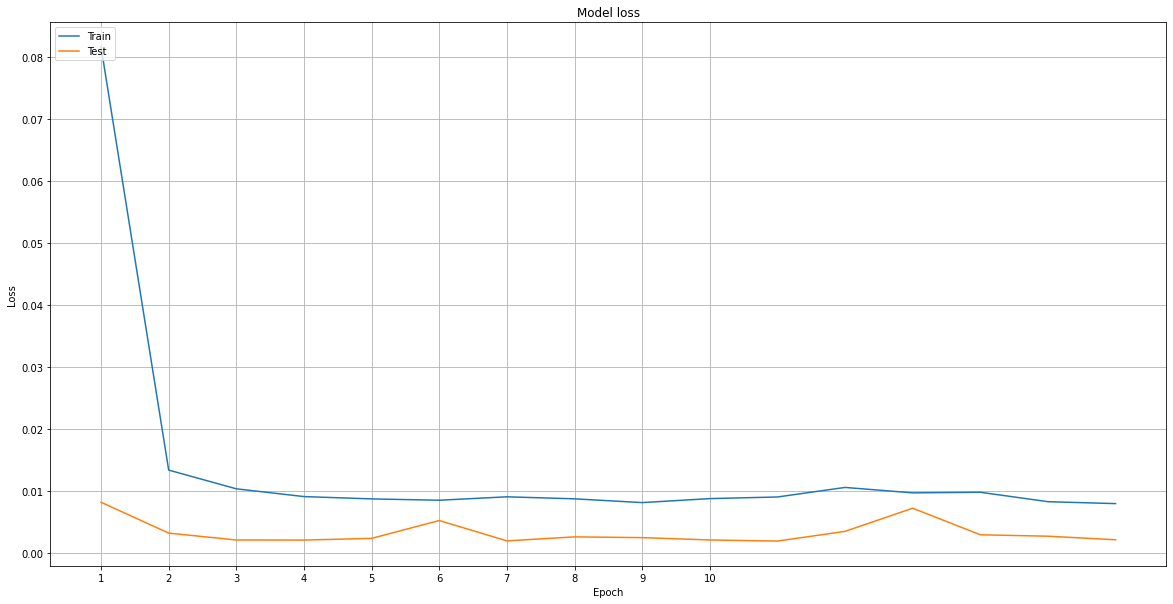

In [50]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 2.57
Mean Absolute Percentage Error (MAPE): 177.26 %
Median Absolute Percentage Error (MDAPE): 106.57 %


,MAE,MAPE,MDAPE
0,2.565501,177.256348,106.574127


In [52]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

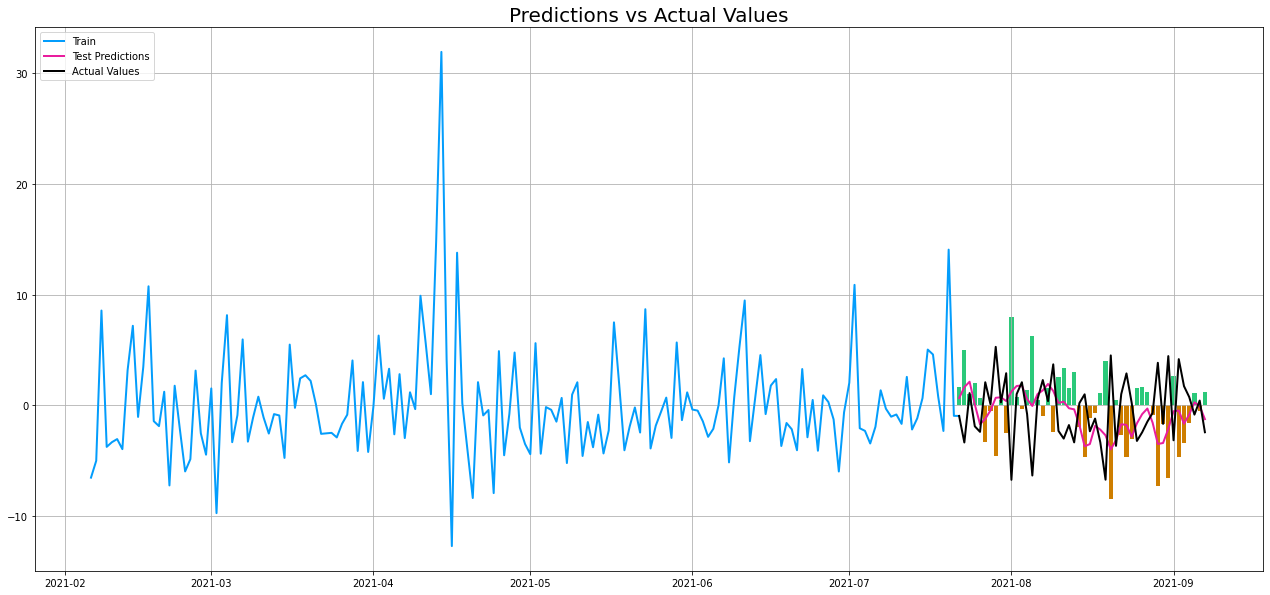

In [53]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: BB SD

### Without Normalization

In [54]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Low', '5D%Change', '3Dir', 'Volume', 'Daily%Change', '3D%Change', '4Dir', '5Dir', '7Dir', '6Dir', '7D%Change', 'SD_log', '6D%Change', '4D%Change', 'High', 'Dir', 'Close', 'Open', '2D%Change', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,0.509947,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,4.249764,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,6.872453,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,4.257568,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,3.521333,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [55]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,2.486682,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,2.486682
246,1.265153,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,1.265153
247,0.900125,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,0.900125
248,0.964008,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,0.964008
249,0.663311,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,0.663311


In [56]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [57]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.9999999999999999
0.9999999999999999


In [58]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'BB_woSentiment_SD_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0228
Epoch 1: val_loss improved from inf to 0.01126, saving model to BB_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 3s 65ms/step - loss: 0.0219 - val_loss: 0.0113
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.0111
Epoch 2: val_loss improved from 0.01126 to 0.00150, saving model to BB_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 0s 15ms/step - loss: 0.0111 - val_loss: 0.0015
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0109
Epoch 3: val_loss did not improve from 0.00150
12/12 [==============================] - 0s 13ms/step - loss: 0.0109 - val_loss: 0.0065
Epoch 4/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0114
Epoch 4: val_loss did not improve from 0.00150
12/12 [==============================] - 0s 12ms/step - loss: 0.0105 - val_loss: 0.0057
Epoch 5/100
12/12 [=========================

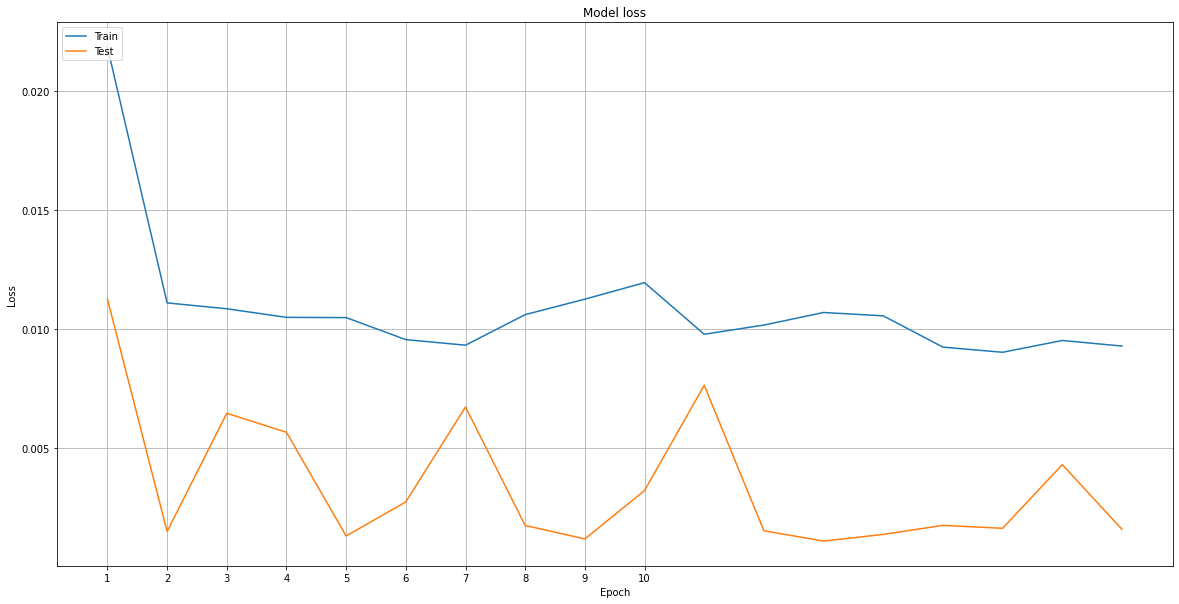

In [60]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [61]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.43
Mean Absolute Percentage Error (MAPE): 46.23 %
Median Absolute Percentage Error (MDAPE): 35.56 %


,MAE,MAPE,MDAPE
0,0.426122,46.230063,35.560602


In [62]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

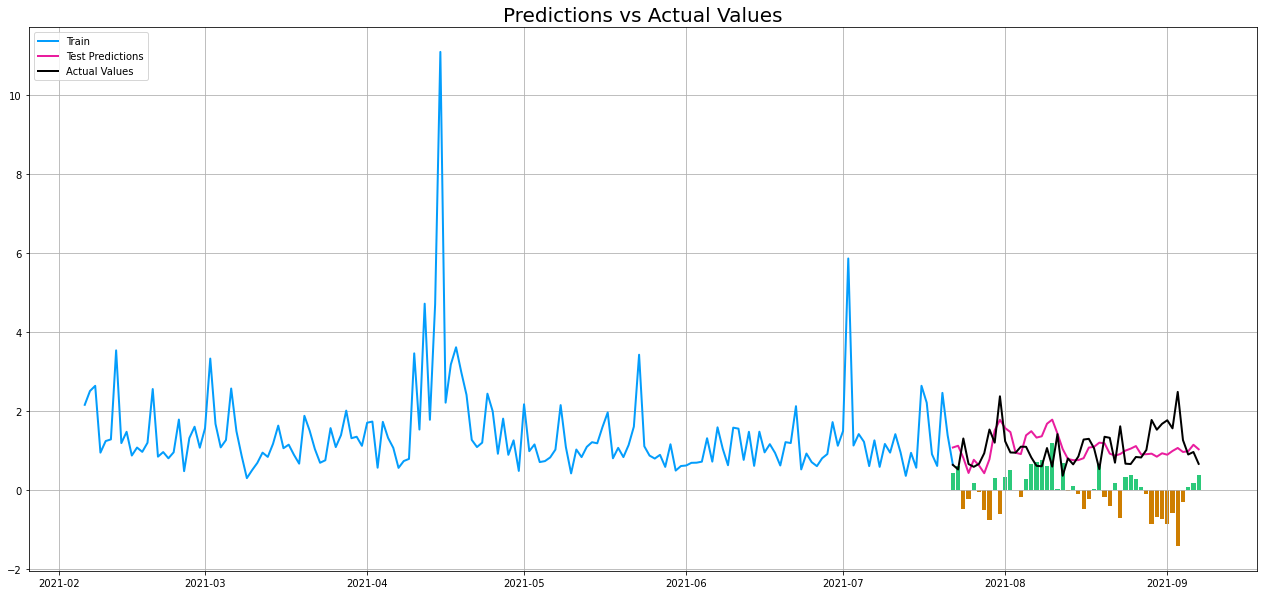

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [65]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Low', '5D%Change', '3Dir', 'Volume', 'Daily%Change', '3D%Change', '4Dir', '5Dir', '7Dir', '6Dir', '7D%Change', 'SD_log', '6D%Change', '4D%Change', 'High', 'Dir', 'Close', 'Open', '2D%Change', '2Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,0.509947,2,-0.261438,1.0,9416000.0,0.0,7.69,13.710880,7.48,15.082956,...,0.925928,-0.834819,1.0,8.073657,1.0,1.0,12.703104,0.433953,15.957450,7.63
8,4.249764,3,-2.490171,0.0,8345500.0,0.0,7.65,5.382438,7.40,13.069911,...,-2.745099,-0.673449,1.0,-1.587300,1.0,1.0,10.879285,0.509947,9.896604,7.44
9,6.872453,4,22.446231,1.0,65231300.0,1.0,7.51,20.502642,7.47,34.564249,...,19.397110,1.446863,1.0,19.084961,1.0,1.0,29.036823,4.249764,35.767505,9.11
10,4.257568,1,8.013178,1.0,153854700.0,1.0,10.68,28.627451,9.40,46.646797,...,32.258066,1.927521,1.0,28.964613,1.0,1.0,30.158733,6.872453,39.376774,9.84
11,3.521333,2,25.508132,1.0,112483200.0,1.0,10.85,61.861077,10.58,74.929185,...,35.565322,1.448698,1.0,65.994628,1.0,1.0,61.437911,4.257568,63.359795,12.35


In [66]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,2.486682,2,4.166665,1.0,15025300.0,1.0,9.00,3.583423,8.99,5.233220,...,0.446533,1.0,5.353078,1.0,1.0,7.558135,1.562885,6.812935,9.25,2.486682
246,1.265153,3,1.729728,1.0,20581000.0,1.0,9.05,7.175400,8.61,8.660508,...,0.910949,1.0,2.617228,1.0,1.0,5.375135,2.486682,9.418598,9.41,1.265153
247,0.900125,0,0.743886,1.0,9882600.0,1.0,9.26,3.380583,8.99,10.232548,...,0.235193,1.0,6.756750,1.0,1.0,7.972663,1.265153,6.159006,9.48,0.900125
248,0.964008,1,-0.843881,1.0,8183100.0,0.0,9.43,5.855850,9.25,5.263150,...,-0.105222,1.0,1.621617,1.0,1.0,2.508174,0.900125,7.061502,9.40,0.964008
249,0.663311,2,0.425532,1.0,6407900.0,1.0,9.43,2.054050,9.32,7.517083,...,-0.036656,1.0,0.318807,1.0,1.0,6.306300,0.964008,2.944378,9.44,0.663311


In [67]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [68]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.9999999999999999
0.9999999999999999


In [69]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'BB_woSentiment_SD_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0482
Epoch 1: val_loss improved from inf to 0.02695, saving model to BB_woSentiment_SD_Normalized.h5
12/12 [==============================] - 3s 72ms/step - loss: 0.0450 - val_loss: 0.0270
Epoch 2/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0135
Epoch 2: val_loss improved from 0.02695 to 0.00093, saving model to BB_woSentiment_SD_Normalized.h5
12/12 [==============================] - 0s 17ms/step - loss: 0.0173 - val_loss: 9.3254e-04
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.0135
Epoch 3: val_loss did not improve from 0.00093
12/12 [==============================] - 0s 13ms/step - loss: 0.0135 - val_loss: 0.0048
Epoch 4/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0119
Epoch 4: val_loss did not improve from 0.00093
12/12 [==============================] - 0s 12ms/step - loss: 0.0119 - val_loss: 0.0017
Epoch 5/100
12/12 [==============================]

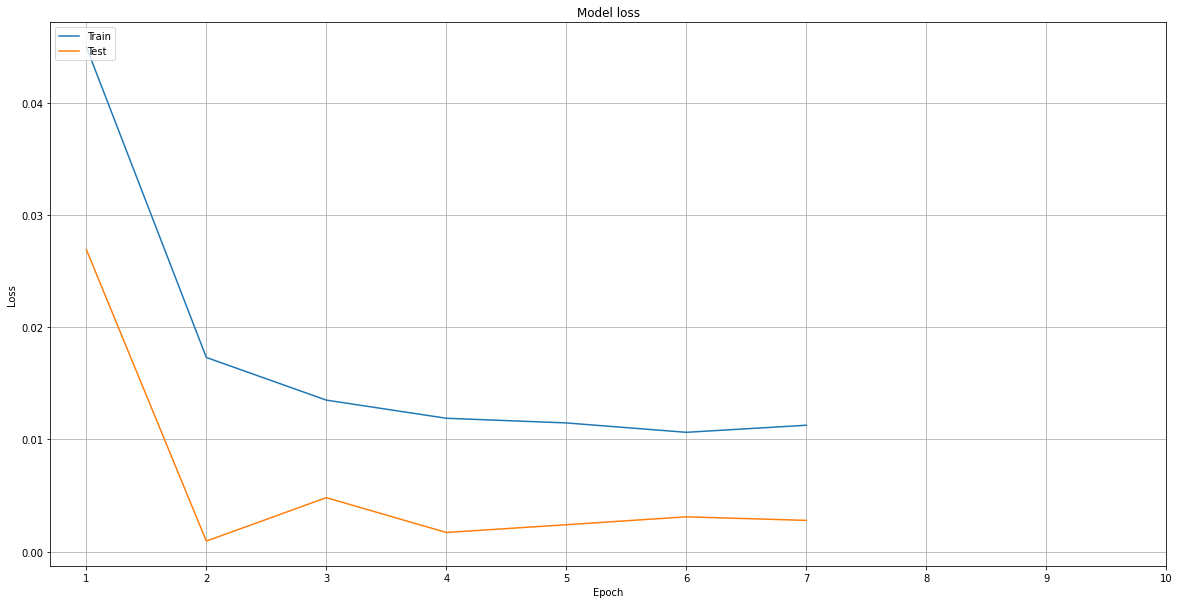

In [71]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [72]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.37
Mean Absolute Percentage Error (MAPE): 35.71 %
Median Absolute Percentage Error (MDAPE): 31.98 %


,MAE,MAPE,MDAPE
0,0.370261,35.708041,31.983666


In [73]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

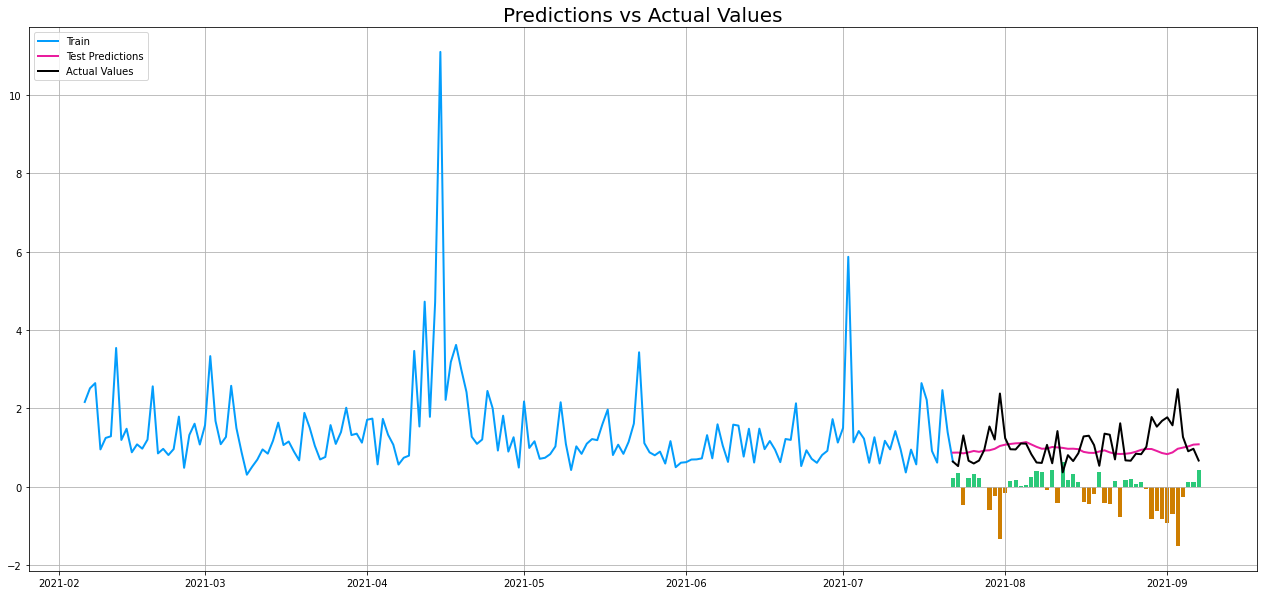

In [74]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()